# **Text Classifier with the IMDB Reviews Dataset**


This notebook showcases the implementation of text classification model using LSTM networks for sentiment analysis. Its purpose is to distinguish between positive and negative movie reviews in the [IMDB Reviews dataset](http://ai.stanford.edu/~amaas/data/sentiment/). Additionally, it includes visualization of word embeddings generated post-training.

For a more robust implementation, please visit my upcoming [notebook](https://github.com/JersonGB22/TextClassification-TensorFlow/blob/main/models_transformers/SentimentAnalysis_RoBERTa_IMDB.ipynb), where a Transformer network is implemented to classify IMDB reviews, achieving better results.

### **Imports**

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import textwrap
from IPython.core.display import HTML
from google.colab import drive
import imageio.v2 as imageio
import os

### **Parameters**

In [2]:
epochs = 5
batch_size = 128
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
vocab_size = 50000 #Including padding and unknown tokens
embedding_dim = 128

### **Load and Preprocess the Dataset**

In [3]:
(train_dataset, test_dataset), info = tfds.load("imdb_reviews",
                                                split=["train + test[:60%]", "test[60%:]"],
                                                as_supervised=True,
                                                with_info=True)
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
    

In [4]:
len(train_dataset), len(test_dataset)

(40000, 10000)

In [5]:
train_dataset = train_dataset.shuffle(buffer_size, seed=123).batch(batch_size).prefetch(AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)

In [6]:
for texts, labels in train_dataset.take(1):
  print(texts[:3].numpy(), "\n")
  print(labels[:3].numpy())

[b'Will Smith is smooth as usual in the movie Hitch. Smiths character Hitch is a date doctor. He dates Mendes character who is a gossip columnist. At one point Hitch shows his love interest her Great Grandfathers name in the immigration book at Ellis Island pretending what is actually an arranged event is a coincidence. Not long after I mentioned starlight in my previous review today. There was a view of the starry sky in survivor hinting that My Moon 168 Rtexas already knew that was going to be there due to faster than light communications.<br /><br />The male star from the show The King of Queens is very funny in this movie especially his dance moves. The allergic reaction on Hitchs face is a little cruel to laugh at even though it is just pretend.<br /><br />My latest message from my Daughter Julias Artificial Intelligence computer on the Creator of Humans Home world Coaltrain that my Moon 168 as part of Moonfleet is near says: "Daddy I\'m Okay again." Her messages are always very s

**Text Encoder Creation**

Text processing utilizes the ``TextVectorization`` layer, which encodes text into indices by frequency order (following the padding token and the unknown token), considering up to ``vocab_size``. Index tensors are padded with zeros up to the longest sequence in the batch (unless you set a fixed value for ``output_sequence_length``).

In [7]:
# Create a custom standardization function

@tf.keras.saving.register_keras_serializable()
def preprocessing(text):
  # Convert all text to lowercase
  text = tf.strings.lower(text)
  # Remove HTML tags
  text = tf.strings.regex_replace(text, r"(<br />)+", " ")
  # Remove punctuation
  text = tf.strings.regex_replace(text, r'[!"#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']', "")
  return text

In [8]:
encoder = tf.keras.layers.TextVectorization(max_tokens=vocab_size,
                                            standardize=preprocessing
                                            )
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())

In [9]:
print(encoder.vocabulary_size())
vocab[:10]

50000


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it'],
      dtype='<U72')

In [10]:
encoded_texts = encoder(texts)[:3].numpy()
print(encoded_texts.shape)
encoded_texts

(3, 915)


array([[   81,  1399,     7, ...,     0,     0,     0],
       [10408,  1185,    38, ...,     0,     0,     0],
       [    2,    19,     7, ...,     0,     0,     0]])

In [11]:
# Visualizing text processing
print(textwrap.fill(texts[0].numpy().decode("utf-8"), width=100), "\n")
print(textwrap.fill(" ".join(vocab[encoded_texts[0]]), width=100))

Will Smith is smooth as usual in the movie Hitch. Smiths character Hitch is a date doctor. He dates
Mendes character who is a gossip columnist. At one point Hitch shows his love interest her Great
Grandfathers name in the immigration book at Ellis Island pretending what is actually an arranged
event is a coincidence. Not long after I mentioned starlight in my previous review today. There was
a view of the starry sky in survivor hinting that My Moon 168 Rtexas already knew that was going to
be there due to faster than light communications.<br /><br />The male star from the show The King of
Queens is very funny in this movie especially his dance moves. The allergic reaction on Hitchs face
is a little cruel to laugh at even though it is just pretend.<br /><br />My latest message from my
Daughter Julias Artificial Intelligence computer on the Creator of Humans Home world Coaltrain that
my Moon 168 as part of Moonfleet is near says: "Daddy I'm Okay again." Her messages are always very
short

### **Build the Model**

In [12]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(123) #For reproducibility

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=encoder.vocabulary_size(),
                              output_dim=embedding_dim,
                              mask_zero=True, #To handle variable sequence lengths
                              name="embedding"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 128)         6400000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

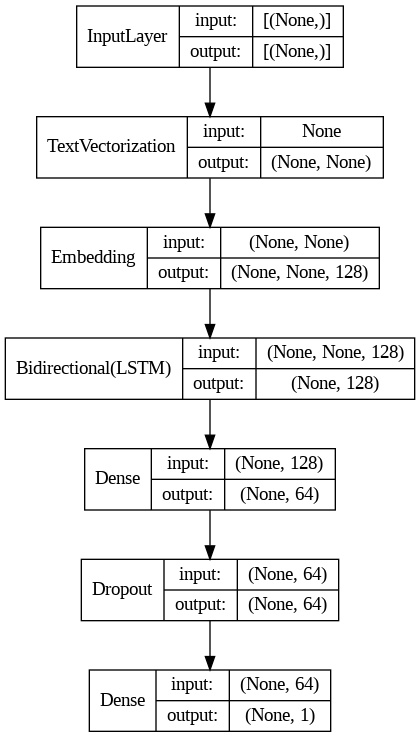

In [13]:
# Visualizing the architecture of the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

### **Compile and Train the Model**

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="binary_crossentropy",
              metrics="accuracy")

In [15]:
tf.random.set_seed(123)
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

Epoch 1/5
313/313 [==============================] - 71s 193ms/step - loss: 0.5963 - accuracy: 0.6759 - val_loss: 0.3902 - val_accuracy: 0.8472
Epoch 2/5
313/313 [==============================] - 51s 161ms/step - loss: 0.3190 - accuracy: 0.8759 - val_loss: 0.2893 - val_accuracy: 0.8831
Epoch 3/5
313/313 [==============================] - 44s 139ms/step - loss: 0.2229 - accuracy: 0.9195 - val_loss: 0.3007 - val_accuracy: 0.8886
Epoch 4/5
313/313 [==============================] - 40s 129ms/step - loss: 0.1693 - accuracy: 0.9426 - val_loss: 0.2578 - val_accuracy: 0.8989
Epoch 5/5
313/313 [==============================] - 36s 116ms/step - loss: 0.1242 - accuracy: 0.9611 - val_loss: 0.2690 - val_accuracy: 0.9049


**Save model**

In [16]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [17]:
model.save("/content/drive/MyDrive/models/SentimentAnalysis_LSTM_IMDB.keras")

### **Dataset Evaluation**

In [18]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.08582794666290283, 0.9777500033378601]
[0.26899874210357666, 0.9049000144004822]


The training set achieves an accuracy of 97.8% in just 5 epochs, while the testing set accuracy is 90.5%. This suggests the model is good but exhibits overfitting issues, despite expanding the training set and utilizing a dropout layer. Even if we add a few more epochs, the training set accuracy might reach 100%, but the testing set accuracy would start to decrease. To achieve better results, it would be advisable to further expand the training set or even use more robust architectures like transformer networks.

In [19]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, epochs=epochs):
  losses = history.history[metric]
  val_losses = history.history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = metric.capitalize()

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

**Interactive graphics**

In [20]:
plot_metrics()

In [21]:
plot_metrics(metric="accuracy")

**Images for GitHub**

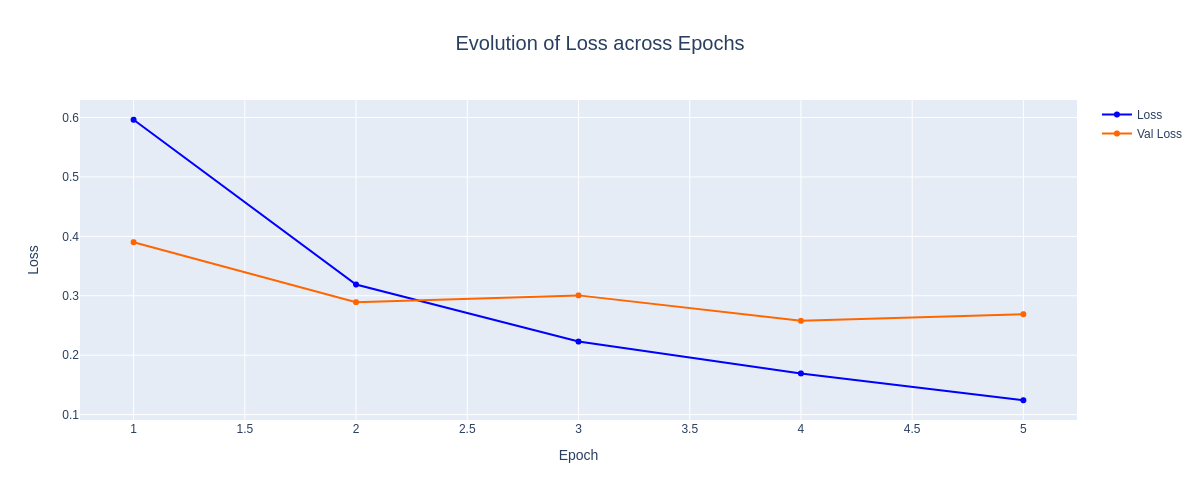

In [10]:
plot_metrics(renderer="png")

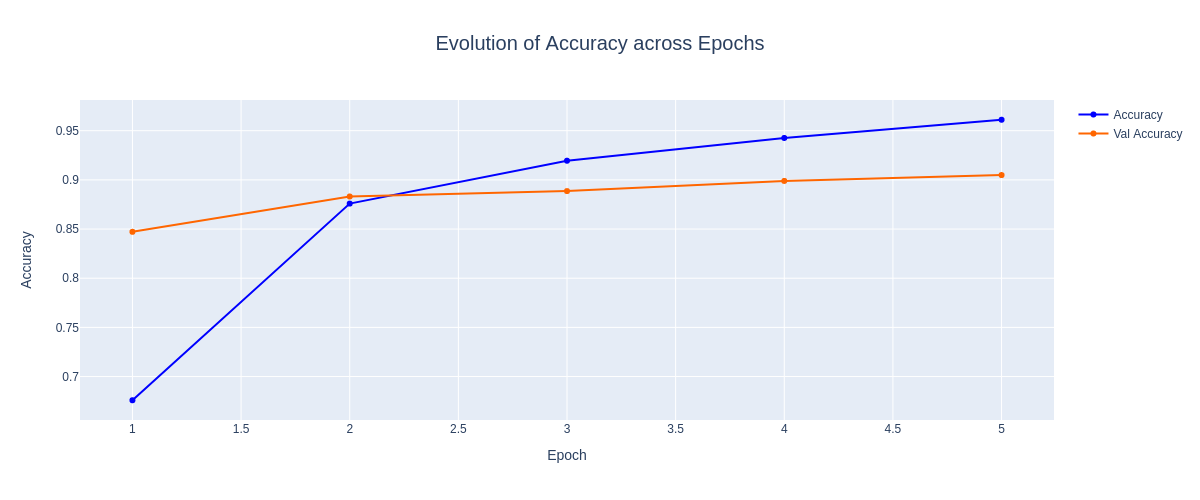

In [11]:
plot_metrics(renderer="png", metric="accuracy")

**Confusion Matrix**

In [25]:
labels_test = test_dataset.unbatch().map(lambda text, label: label)
labels_test = np.array(list(labels_test.as_numpy_iterator()))

labels_test_pred = model.predict(test_dataset, verbose=0).squeeze()
labels_test_pred = (labels_test_pred>=0.5).astype(np.int32)

In [26]:
# Consolidating the accuracy of the testing set
np.mean(labels_test == labels_test_pred)

0.9049

Total negatives:  4970 ; Total positives:  5030


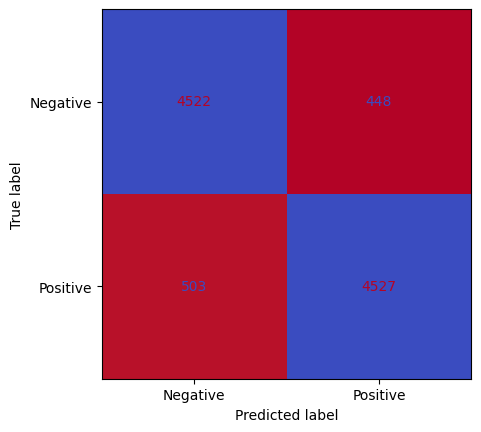

In [27]:
cm = confusion_matrix(labels_test, labels_test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"])
cmd.plot(colorbar=False, cmap="coolwarm_r");
print("Total negatives: ", np.bincount(labels_test)[0], "; Total positives: ", np.bincount(labels_test)[1])

In [28]:
(448/4970)*100, (503/5030)*100

(9.014084507042254, 10.0)

It is observed that the model predicts incorrectly almost equally between negative opinions of incorrect reviews, as reflected in a false positive rate of 9%, compared to false negatives of 10%, which are positive opinions of incorrect reviews, thus the model predicts in a balanced manner.

### **Predictions with the trained model**

In [14]:
# Custom standardization function

@tf.keras.saving.register_keras_serializable()
def preprocessing(text):
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, r"(<br />)+", " ")
  text = tf.strings.regex_replace(text, r'[!"#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']', "")
  return text

In [15]:
# Load model
tf.keras.backend.clear_session()
model = tf.keras.models.load_model("/content/drive/MyDrive/models/SentimentAnalysis_LSTM_IMDB.keras")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 128)         6400000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [17]:
def predict_review(texts, labels, random=True):
  label_names = ["Negative Review", "Positive Review"]
  label_colors = ["red", "green"]
  indice = np.random.choice(len(texts)) if random else 0
  labels_pred = model.predict(texts, verbose=0).squeeze(axis=-1)
  labels_pred = (labels_pred>=0.5).astype(np.int32)

  html_content = f"""
    <b>Review:</b><br><br>
    {texts[indice].numpy().decode("utf-8")}<br><br>
    <b>True Label: <span style="color: {label_colors[labels[indice]]}">{label_names[labels[indice]]}</span></b><br><br>
    <b>Predicted Label: <span style="color: {label_colors[labels_pred[indice]]}">{label_names[labels_pred[indice]]}</span></b>
    """
  display(HTML(html_content))

**Test Dataset**

In [18]:
texts, labels = next(iter(test_dataset))

In [19]:
predict_review(texts, labels, random=False)

In [24]:
predict_review(texts, labels)

In [27]:
# Long Review
predict_review(texts, labels)

In [38]:
# Long Review
predict_review(texts, labels)

**Other Reviews**

In [47]:
text = """
'The Sunrise of Tomorrow' is a cinematic masterpiece that truly captures the essence of human resilience.
The performances are stellar, particularly the lead actor who delivers a heart-wrenching performance that leaves you on the edge of your seat.
The cinematography is breathtaking, with each frame painting a beautiful picture that stays with you long after the movie ends.
The plot is well-crafted, with unexpected twists that keep you engaged throughout.
This movie is a must-watch for anyone seeking a profound cinematic experience.
"""
text = tf.constant([text], tf.string)
label = tf.constant([1], tf.int32)

predict_review(text, label)

In [48]:
text = """
I had high hopes for "The Sunrise of Tomorrow", but unfortunately, it fell short of expectations.
The plot was predictable and lacked depth, making it difficult to connect with the characters on any meaningful level.
The performances felt forced and lacked the emotional depth necessary for such a storyline.
The cinematography, while visually appealing, couldn't make up for the lackluster script.
Overall, the movie felt like a missed opportunity to explore an interesting concept.
"""
text = tf.constant([text], tf.string)
label = tf.constant([0], tf.int32)

predict_review(text, label)

In [49]:
# Complex positive review, incorporating seemingly negative words.

text = """
I'm absolutely disgusted that this movie isn't being sold. Everyone who loves this film should email Disney to increase the demand for it.
Eventually, they'd have to sell it, and then I'd buy copies for everybody I know. Everyone and everything in this movie did a good job,
and I can't figure out why Disney hasn't put it on DVD or even on VHS in rental stores.
I haven't seen any copies. This is a fantastic movie that deserves to be seen by all the kids in the new generation.
They're missing out, and I think they deserve the chance to experience it.
"""
text = tf.constant([text], tf.string)
label = tf.constant([1], tf.int32)

predict_review(text, label)

It is evident that the model has classified the review correctly, suggesting that it is capable of adequately capturing semantic relationships in short reviews, even when they are complex, thanks to the use of LSTM networks.

### **Visualize Word Embeddings with Principal Component Analysis (PCA)**

In [50]:
# Obtaining the vocabulary from the encoder layer and the weights from the trained embedding layer

vocab = model.layers[0].get_vocabulary()
vocab = {word:i for i, word in enumerate(vocab)}

embedding = model.get_layer("embedding").get_weights()[0]
embedding.shape #(vocab_size, embedding_dim)

(50000, 128)

In [51]:
def compute_pca(X, n_components=2):
  pca = PCA(n_components=n_components, random_state=42)
  X_pca = pca.fit_transform(X)
  return X_pca

In [52]:
embedding_2d = compute_pca(embedding)
embedding_3d = compute_pca(embedding, n_components=3)

embedding_2d.shape, embedding_3d.shape

((50000, 2), (50000, 3))

In [62]:
# Some exemplary words
words = ["good", "excellent", "great", "fantastic", "amazing", "wonderful", "outstanding", "superb", "delightful", "phenomenal",
         "bad", "terrible", "awful", "horrible", "mediocre", "dreadful", "poor", "lousy", "disappointing", "atrocious"]

colors = ["green"]*10 + ["red"]*10

In [63]:
words_2d = np.array([embedding_2d[vocab.get(word, 1)] for word in words]) #Index 1 corresponds to [UNK]
words_3d = np.array([embedding_3d[vocab.get(word, 1)] for word in words])

**With Plotly (interactive graph)**

In [64]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=words_2d[:10, 0], y=words_2d[:10, 1],
                         mode="markers+text", marker_color="green",
                         text=words[:10], textposition="top center",
                         marker_size=10, textfont_size=13,
                         name="positive"))

fig.add_trace(go.Scatter(x=words_2d[10:, 0], y=words_2d[10:, 1],
                         mode="markers+text", marker_color="red",
                         text=words[10:], textposition="top center",
                         marker_size=10, textfont_size=13,
                         name="negative"))

fig.update_layout(title="<b>2D Embeddings of IMDB Reviews Words</b>",
                  title_font=dict(size=18), title_x=0.5, height=800, width=1200,
                  xaxis_title="<b>$Z_1$</b>", yaxis_title="<b>$Z_2$</b>")

fig.show()

In [65]:
fig = go.Figure()

fig.add_trace(go.Scatter3d(x=words_3d[:10, 0], y=words_3d[:10, 1], z=words_3d[:10, 2],
                           mode="markers+text", marker_color="green",
                           text=words[:10], textposition="top center",
                           marker_size=7, textfont_size=13,
                           name="positive"))

fig.add_trace(go.Scatter3d(x=words_3d[10:, 0], y=words_3d[10:, 1], z=words_3d[10:, 2],
                           mode="markers+text", marker_color="red",
                           text=words[10:], textposition="top center",
                           marker_size=7, textfont_size=13,
                           name="negative"))

fig.update_layout(title="<b>3D Embeddings of IMDB Reviews Words</b>",
                  title_font=dict(size=18), title_x=0.5, height=800, width=1200,
                  scene=dict(xaxis_title="<b>Z_1</b>", yaxis_title="<b>Z_2</b>", zaxis_title="<b>Z_3</b>"))

fig.show()

In [66]:
# Function to create gifs

def create_gif(gif_file, fig, fps=1):

  images = []
  angles = np.arange(0, 361, 20)

  # Initial Image
  fig.write_image("temp.png")
  images.append(imageio.imread("temp.png"))
  os.remove("temp.png")

  for angle in angles:
    fig.update_layout(scene_camera=dict(
        eye=dict(x=np.sin(np.radians(angle)), y=np.cos(np.radians(angle)))
        )
    )
    fig.write_image("temp.png")
    images.append(imageio.imread("temp.png"))
    os.remove("temp.png")

  with imageio.get_writer(gif_file, mode="I", loop=0, fps=fps) as writer:
    for image in images:
      writer.append_data(image)

In [67]:
!pip install tensorflow_docs -q

import tensorflow_docs.vis.embed as embed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 7.0 MB/s eta 0:00:00



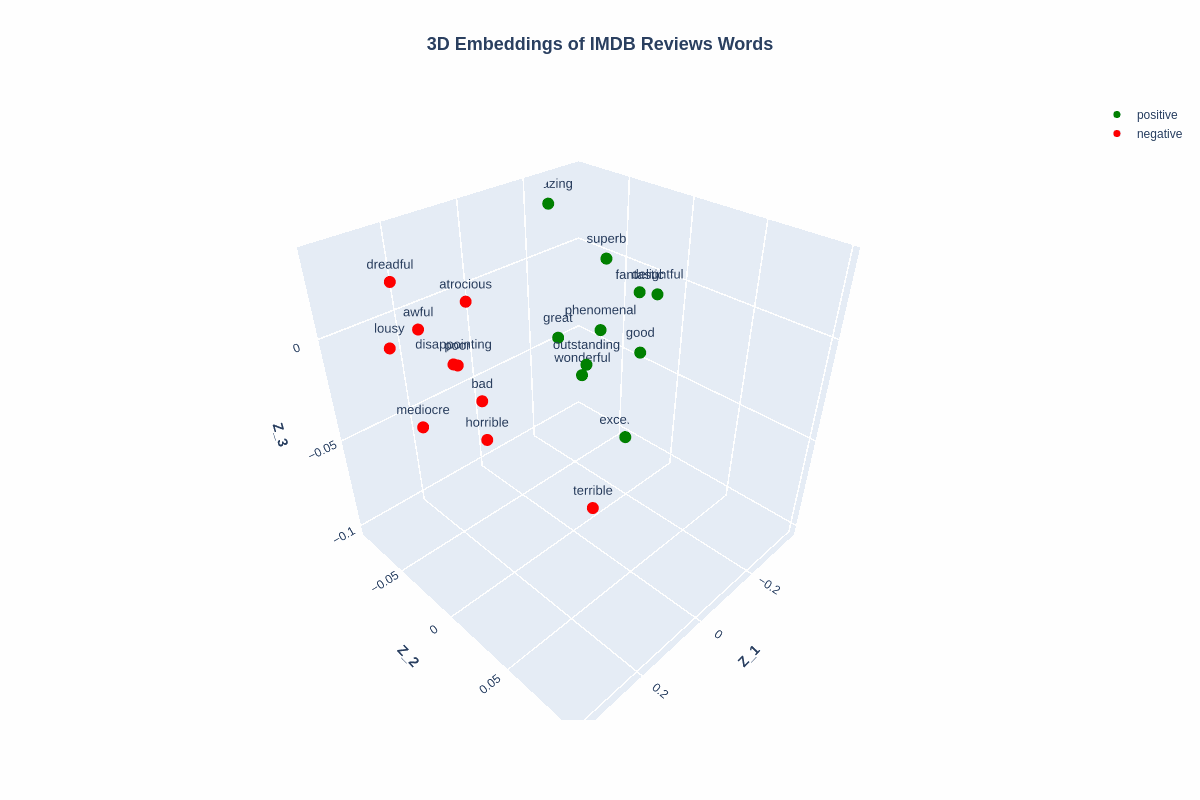

In [68]:
# Generate a GIF of the 3D word embeddings
directory_images = "/content/drive/MyDrive/images/text_classification"
directory_tc = os.path.join(directory_images, "lstm_imdb")
os.makedirs(directory_tc, exist_ok=True)
gif_file = os.path.join(directory_tc, "embedding_3d.gif")

create_gif(gif_file, fig, fps=0.5)
embed.embed_file(gif_file)

**With Matplotlib (for GitHub)**

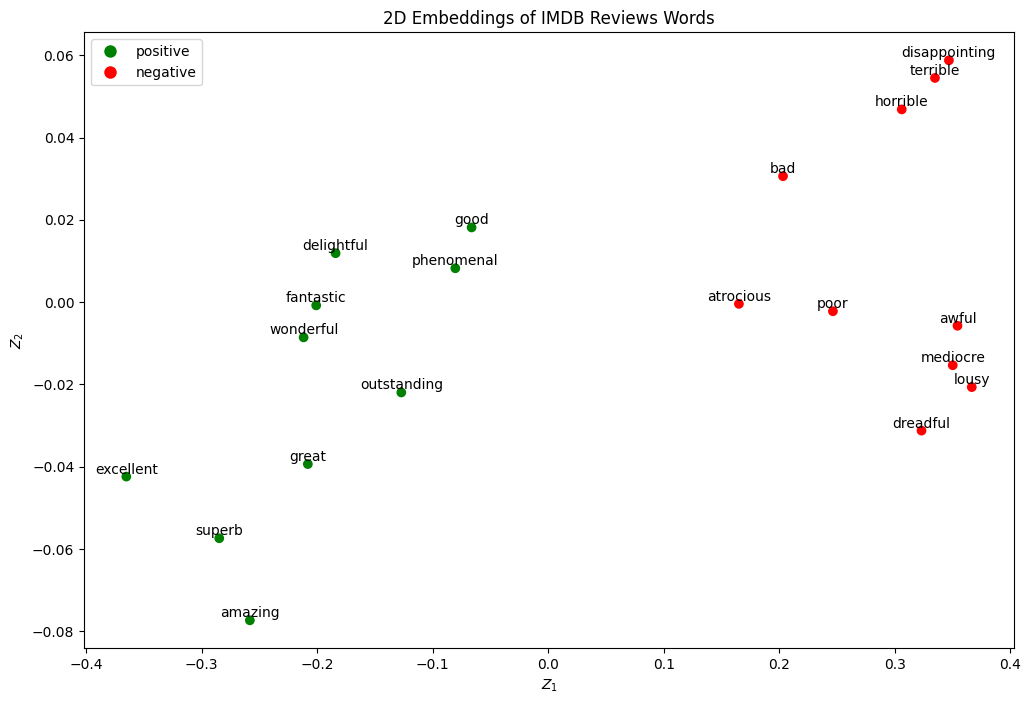

In [69]:
plt.figure(figsize=(12, 8))
plt.scatter(words_2d[:, 0], words_2d[:, 1], c=colors)
for i, word in enumerate(words):
    plt.annotate(word, xy=(words_2d[i, 0], words_2d[i, 1]), ha="center", va="bottom")

legend_handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=10, label=label)
                  for color, label in zip(["green", "red"], ["positive", "negative"])]
plt.legend(handles=legend_handles, loc="best")

plt.xlabel("$Z_1$")
plt.ylabel("$Z_2$")
plt.title("2D Embeddings of IMDB Reviews Words")
plt.show()

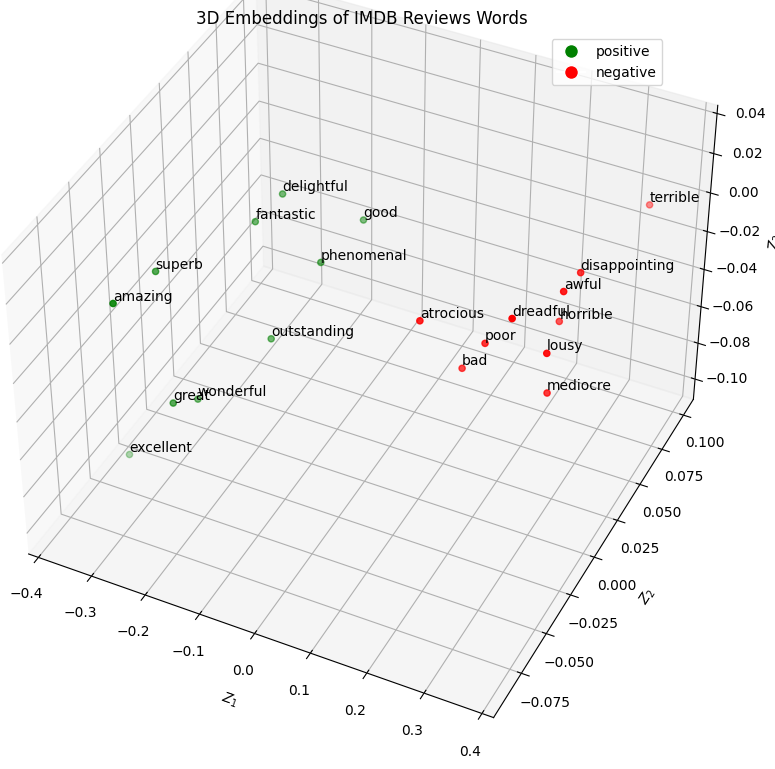

In [98]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(words_3d[:, 0], words_3d[:, 1], words_3d[:, 2], c=colors)

for i, word in enumerate(words):
    ax.text(words_3d[i, 0], words_3d[i, 1], words_3d[i, 2], word, ha="left", va="bottom")

legend_handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=10, label=label)
                  for color, label in zip(["green", "red"], ["positive", "negative"])]
plt.legend(handles=legend_handles, loc="best")

ax.view_init(elev=40, azim=296)
ax.set_box_aspect(None, zoom=1.3)

ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
ax.set_zlabel("$Z_3$")
plt.title("3D Embeddings of IMDB Reviews Words")
plt.show()

Thanks to the use of **PCA**, we can now visualize the trained weights of the embedding layer in both 2D and 3D, where the vector representation of each vocabulary word, previously of dimension 128, has been reduced and projected into a lower-dimensional space. This technique allows us to understand word distribution more clearly. Moreover, by observing the arrangement of words in the vector space, we can infer that the model has been trained successfully. Common words in positive reviews cluster coherently, as do words associated with negative reviews, suggesting a good capture of semantic relationships. Furthermore, a clear separation between these two groups of words is observed in the vector space, indicating good discrimination capability of the model.